In [20]:
import os
import sys; sys.path.append("..")
import warnings; warnings.filterwarnings("ignore")
from dotenv import load_dotenv; load_dotenv()
%load_ext autoreload
%autoreload 2

# https://yuque.antfin-inc.com/ray-project/manual/diwe1q
from rag.config import ROOT_DIR


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
from pathlib import Path
from rag.config import EFS_DIR
print(EFS_DIR)
DOCS_DIR = Path(EFS_DIR)
files = [{"path": path} for path in DOCS_DIR.rglob("*.md") if not path.is_dir()]
len(files)

/Users/paer/Documents/work/codes/RAG_ray


1

In [23]:
import matplotlib.pyplot as plt
from rag.data import extract_sections

In [24]:
import re

def extract_md_sections(record):
    with open(record["path"], "r", encoding="utf-8") as file:
        file_content = file.read()
        sections = re.split(r'\n# ', file_content)[1:]  # 使用正则表达式以一级标题切分文本并去除第一个空项
        print(len(sections))
        section_list = []
        for section in sections:
            section_list.append({"source": record["path"], "text": section})
        return section_list



In [25]:
context = tmp_sections[0:5]
context

[{'source': PosixPath('/Users/paer/Documents/work/codes/RAG_ray/1.4.x.md'),
  'text': "1.4.18.3\n\n- 发布时间：2023.07.04\n- 镜像：reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230718100457-1.4.18.3-0a6d789a\n- 公共试用集群：[ray-public-em14-gray](https://antc.alipay.com/raycloud/cluster/detail/186000185)（提供给大家测试使用，可以随意提交，但是不要发正式的作业）。\n- Maven依赖：\n```xml\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-api</artifactId>\n  <version>1.4.18.3</version>\n</dependency>\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-runtime</artifactId>\n  <version>1.4.18.3</version>\n</dependency>\n```\n\n- pip\n```\npip install -i https://artifacts.antgroup-inc.cn/simple/ 'ant-ray==1.4.18.3'\n```\n\ncpp:\n```\nhttp://raylet.cn-hangzhou-alipay-b.oss-cdn.aliyun-inc.com/ci/ant-ray-cpp-9d60b4536f6e9fe57b31cdd3a3813d011fbae35489ddcbd5353b8583677ff65e.zip\nsha256: 9d60b4536f6e9fe57b31cdd3a3813d011fbae35489ddcbd5353b8583677ff65e\nroot_dir_name: ray-1.4.18.3\n```\n\n- G

In [27]:
files

[{'path': PosixPath('/Users/paer/Documents/work/codes/RAG_ray/1.4.x.md')}]

In [30]:
sections_data = list(map(extract_md_sections, files))[0]

34


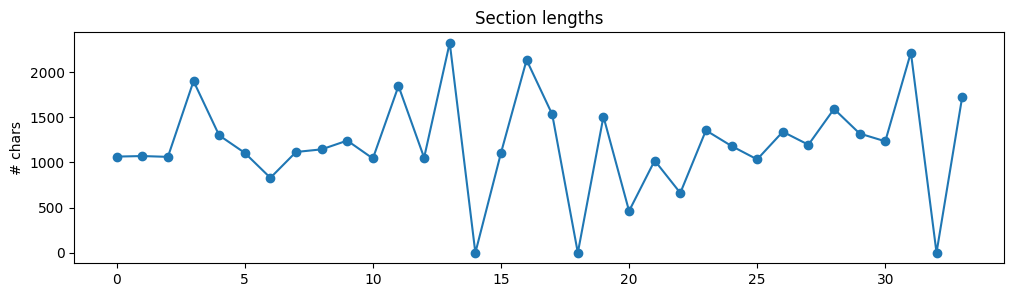

In [32]:
section_lengths = []
for section in sections_data:
    section_lengths.append(len(section["text"]))
# Plot
plt.figure(figsize=(12, 3))
plt.plot(section_lengths, marker='o')
plt.title("Section lengths")
plt.ylabel("# chars")
plt.show()

In [33]:
from functools import partial
from langchain.text_splitter import RecursiveCharacterTextSplitter

# Text splitter
chunk_size = 2000
chunk_overlap = 100
text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
    length_function=len)

def chunk_section(section, chunk_size, chunk_overlap):
    text_splitter = RecursiveCharacterTextSplitter(
        separators=["\n\n", "\n", " ", ""],
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len)
    chunks = text_splitter.create_documents(
        texts=[section["text"]], 
        metadatas=[{"source": section["source"]}])
    return [{"text": chunk.page_content, "source": str(chunk.metadata["source"])} for chunk in chunks]

In [55]:
# Chunking
chunks_data = list(map(partial(
    chunk_section, 
    chunk_size=chunk_size, 
    chunk_overlap=chunk_overlap), sections_data))

In [56]:
print(f"{len(chunks_data)} chunks")
for i in range(5):
    print(f"Chunk {i}: {chunks_data[i]}")


34 chunks
Chunk 0: [{'text': "1.4.18.3\n\n- 发布时间：2023.07.04\n- 镜像：reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230718100457-1.4.18.3-0a6d789a\n- 公共试用集群：[ray-public-em14-gray](https://antc.alipay.com/raycloud/cluster/detail/186000185)（提供给大家测试使用，可以随意提交，但是不要发正式的作业）。\n- Maven依赖：\n```xml\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-api</artifactId>\n  <version>1.4.18.3</version>\n</dependency>\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-runtime</artifactId>\n  <version>1.4.18.3</version>\n</dependency>\n```\n\n- pip\n```\npip install -i https://artifacts.antgroup-inc.cn/simple/ 'ant-ray==1.4.18.3'\n```\n\ncpp:\n```\nhttp://raylet.cn-hangzhou-alipay-b.oss-cdn.aliyun-inc.com/ci/ant-ray-cpp-9d60b4536f6e9fe57b31cdd3a3813d011fbae35489ddcbd5353b8583677ff65e.zip\nsha256: 9d60b4536f6e9fe57b31cdd3a3813d011fbae35489ddcbd5353b8583677ff65e\nroot_dir_name: ray-1.4.18.3\n```\n\n- Git tag：ant-ray-1.4.18.3\n- Git commit: 0a6d789a32b26eb1d0

In [44]:
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.embeddings.fake import FakeEmbeddings
import numpy as np

In [49]:
def get_embedding_model(embedding_model_name, model_kwargs, encode_kwargs):
    if embedding_model_name == "text-embedding-ada-002":
        embedding_model = OpenAIEmbeddings(
            model=embedding_model_name,
            openai_api_base=os.environ["OPENAI_API_BASE"],
            openai_api_key=os.environ["OPENAI_API_KEY"])
    else:
        # model_name = "thenlper/gte-base"
        # model_kwargs = {'device': 'cpu'}
        # encode_kwargs = {'normalize_embeddings': False}
        embedding_model = FakeEmbeddings(
                                size=768,
                              model_name=embedding_model_name,
                              model_kwargs=model_kwargs,
                              encode_kwargs=encode_kwargs
                          )
    return embedding_model

In [66]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(
            embedding_model_name=model_name,
            model_kwargs={"device": "cpu"},
            encode_kwargs={"device": "cpu", "batch_size": 100})
    def __call__(self, batch):
        if (len(batch)>0):
            embeddings = self.embedding_model.embed_documents(batch[0]["text"])
            return {"text": batch[0]["text"], "source": batch[0]["source"], "embeddings": embeddings}

In [67]:
# Embed chunks
embedding_model_name = "thenlper/gte-base"
embedder = EmbedChunks(embedding_model_name)
embedded_chunks = list(map(embedder, chunks_data))


In [72]:
sample = embedded_chunks[0]
print ("embedding size:", len(sample["embeddings"]))
print (sample["text"])

embedding size: 1064
1.4.18.3

- 发布时间：2023.07.04
- 镜像：reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230718100457-1.4.18.3-0a6d789a
- 公共试用集群：[ray-public-em14-gray](https://antc.alipay.com/raycloud/cluster/detail/186000185)（提供给大家测试使用，可以随意提交，但是不要发正式的作业）。
- Maven依赖：
```xml
<dependency>
  <groupId>io.ant-ray</groupId>
  <artifactId>ray-api</artifactId>
  <version>1.4.18.3</version>
</dependency>
<dependency>
  <groupId>io.ant-ray</groupId>
  <artifactId>ray-runtime</artifactId>
  <version>1.4.18.3</version>
</dependency>
```

- pip
```
pip install -i https://artifacts.antgroup-inc.cn/simple/ 'ant-ray==1.4.18.3'
```

cpp:
```
http://raylet.cn-hangzhou-alipay-b.oss-cdn.aliyun-inc.com/ci/ant-ray-cpp-9d60b4536f6e9fe57b31cdd3a3813d011fbae35489ddcbd5353b8583677ff65e.zip
sha256: 9d60b4536f6e9fe57b31cdd3a3813d011fbae35489ddcbd5353b8583677ff65e
root_dir_name: ray-1.4.18.3
```

- Git tag：ant-ray-1.4.18.3
- Git commit: 0a6d789a32b26eb1d0d3f4c8b77e5be10df39fb4
## Release notes
#

In [73]:
import psycopg
from pgvector.psycopg import register_vector
# os.environ["MIGRATION_FP"] = f"../migrations/vector-{EMBEDDING_DIMENSIONS[embedding_model_name]}.sql"
# os.environ["SQL_DUMP_FP"] = f"{EFS_DIR}/sql_dumps/{embedding_model_name.split('/')[-1]}_{chunk_size}_{chunk_overlap}.sql"
# print(os.environ["MIGRATION_FP"])
# print(os.environ["SQL_DUMP_FP"])

In [76]:
os.environ["DB_CONNECTION_STRING"] = "dbname=paer"
class StoreResults:
    def __call__(self, batch):
        with psycopg.connect("dbname=paer") as conn:
            register_vector(conn)
            with conn.cursor() as cur:
                if batch is not None:
                    for text, source, embedding in zip(batch["text"], batch["source"], batch["embeddings"]):
                        cur.execute("INSERT INTO document (text, source, embedding) VALUES (%s, %s, %s)", (text, source, embedding,),)
        return {}

In [78]:
# Index data
store_processer = StoreResults()
mp = list(map(store_processer, embedded_chunks))

In [79]:
def semantic_search(query, embedding_model, k):
    embedding = np.array(embedding_model.embed_query(query))
    with psycopg.connect(os.environ["DB_CONNECTION_STRING"]) as conn:
        register_vector(conn)
        with conn.cursor() as cur:
            cur.execute("SELECT * FROM document ORDER BY embedding <=> %s LIMIT %s", (embedding, k),)
            rows = cur.fetchall()
            semantic_context = [{"id": row[0], "text": row[1], "source": row[2]} for row in rows]
    return semantic_context

In [81]:
query = "1.4.18.2版本的镜像？"

embedding_model = get_embedding_model(
            embedding_model_name=embedding_model_name,
            model_kwargs={"device": "cpu"},
            encode_kwargs={"device": "cpu", "batch_size": 100})

semantic_search(query, embedding_model, 5)

[{'id': 3031, 'text': '.', 'source': '1'},
 {'id': 1512, 'text': '.', 'source': '1'},
 {'id': 2512, 'text': '发', 'source': 'D'},
 {'id': 307, 'text': '发', 'source': 'D'},
 {'id': 993, 'text': '发', 'source': 'D'}]

In [82]:
import requests
import json

def prompt_engine_chat_completion(
  model = "gpt-3.5-turbo-16k",
  system_content="", 
  assistant_content="", 
  user_content="",
):
  url = "https://promptsengine.alipay.com/api/prompt/predict"
  headers = {"Content-Type": "application/json; charset=utf-8"}
  # 四尔那边提供的scene_id, 仅供demo调用，切勿频繁调用。
  scene_id = "RAY_DEMO_ON_AIGC"
  model_config = {"open_ai_model_config": {"model": model, "max_tokens": 10000}}
  prompts = []
  if system_content:
    prompts.append({
        "prompt_template":{"template": system_content},
        "role":"system"
    })
  if assistant_content:
    prompts.append({
        "prompt_template":{"template": assistant_content},
        "role":"assistant"
    })
  if user_content:
    prompts.append({
      "prompt_template":{"template": user_content},
      "role":"user"
    })
  data = {
          "context": {"scene_id":scene_id},
          "prompt_config":prompts,
          "model_config": model_config,
          "extra_config":{"relation_id":"1000"}
          }
  response = requests.post(url, data=json.dumps(data), headers=headers)
  reply = response.json()
  return reply["data"]["open_ai_result"]["model_answer"]["model_result"][0]["content"]

prompt_engine_chat_completion(
  model="gpt-3.5-turbo-16k", 
  system_content="Answer the query using the context provided. Be succinct.",
  user_content=f"query: {query}, context: {context}"
  )

'1.4.18.2版本的镜像是reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230704212350-1.4.18.2-3a934278。'

In [83]:
query = "1.4.18.2版本的镜像？"
context = ""
prompt_engine_chat_completion(
  model="gpt-3.5-turbo-16k", 
  system_content="",
  user_content=f"query: {query}, context: {context}"
  )

'很抱歉，我无法提供特定版本的镜像。请您在相关软件或平台的官方网站或镜像站点上查找1.4.18.2版本的镜像。'

In [85]:
from rag.utils import get_num_tokens, trim
from rag.config import EMBEDDING_DIMENSIONS, MAX_CONTEXT_LENGTHS
class QueryAgent:
    def __init__(self, embedding_model_name="thenlper/gte-base",
                 llm="meta-llama/Llama-2-70b-chat-hf", temperature=0.0, 
                 max_context_length=4096, system_content="", assistant_content=""):
        
        # Embedding model
        self.embedding_model = get_embedding_model(
            embedding_model_name=embedding_model_name, 
            model_kwargs={"device": "cpu"}, 
            encode_kwargs={"device": "cpu", "batch_size": 100})
        
        # Context length (restrict input length to 50% of total context length)
        max_context_length = int(0.5*max_context_length)
        
        # LLM
        self.llm = llm
        self.temperature = temperature
        self.context_length = max_context_length - get_num_tokens(system_content + assistant_content)
        self.system_content = system_content
        self.assistant_content = assistant_content

    def __call__(self, query, num_chunks=5, stream=True):
        # Get sources and context
        context_results = semantic_search(
            query=query, 
            embedding_model=self.embedding_model, 
            k=num_chunks)
            
        # Generate response
        context = [item["text"] for item in context_results]
        sources = [item["source"] for item in context_results]
        user_content = f"query: {query}, context: {context}"
        print(user_content)
        answer = prompt_engine_chat_completion(
            model=self.llm,
            system_content=self.system_content,
            assistant_content=self.assistant_content,
            user_content=trim(user_content, self.context_length))

        # Result
        result = {
            "question": query,
            "sources": sources,
            "answer": answer,
            "llm": self.llm,
        }
        return result

In [86]:
llm = "gpt-3.5-turbo-16k"

In [87]:
query = "1.4.18.2版本的镜像？"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)
result = agent(query=query, stream=False)
result
# print("\n\n", json.dumps(result, indent=2))


query: 1.4.18.2版本的镜像？, context: ['0', '0', 'k', 'k', '.']


{'question': '1.4.18.2版本的镜像？',
 'sources': ['s', 's', 'r', 'r', 'U'],
 'answer': '没有提供足够的上下文来回答这个问题。请提供更多的信息。',
 'llm': 'gpt-3.5-turbo-16k'}

In [66]:
result

{'question': '1.4.18.2版本的镜像？',
 'sources': ['/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md'],
 'answer': '1.4.18.2版本的镜像是reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230704212350-1.4.18.2-3a934278。',
 'llm': 'gpt-3.5-turbo-16k'}

In [91]:
query = "1.4.18版本的新功能有哪些？"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)
result = agent(query=query, stream=False)
result

query: 1.4.18版本的新功能有哪些？, context: ["1.4.18\n\n- 发布时间：\n- 镜像：reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230518104725-1.4.18-e0167eb4\n- 公共试用集群：[ray-public-em14-gray](https://antc.alipay.com/raycloud/cluster/detail/186000185)（提供给大家测试使用，可以随意提交，但是不要发正式的作业）。\n- Maven依赖：\n```xml\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-api</artifactId>\n  <version>1.4.18</version>\n</dependency>\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-runtime</artifactId>\n  <version>1.4.18</version>\n</dependency>\n```\n\n- pip\n```\npip install -i https://artifacts.antgroup-inc.cn/simple/ 'ant-ray==1.4.18'\n```\n\ncpp:\n```\nhttp://raylet.cn-hangzhou-alipay-b.oss-cdn.aliyun-inc.com/ci/ant-ray-cpp-445cdf8f29d7b7acac0671feedcdccd37ab06463f2e6625ca981cffec386b2d8.zip\nsha256: 445cdf8f29d7b7acac0671feedcdccd37ab06463f2e6625ca981cffec386b2d8\nroot_dir_name: ray-1.4.18\n```\n\n- Git tag：ant-ray-1.4.18\n- Git commit: e0167eb4120dc95eab1ba059ebd7ce64c55f

{'question': '1.4.18版本的新功能有哪些？',
 'sources': ['/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md'],
 'answer': '1.4.18版本的新功能有：\n- Ray去依赖，去掉sklean，tensorboard等无关依赖\n- Ray集群镜像中的Ray whl包名字切到ant-ray，并且做唯一版本号\n- 支持worker in container新的运行方式：在用户镜像里安装Ray，选项为“_install_ray”\n- 支持worker启动异常日志透出到event\n- raylet oom killer的内存信息收集方式仿照earlyoom; 现在默认打开\n- 支持用户订阅其他job状态\n- API server的框架集群查询接口支持显示是否开启 job quota limit\n- 引入Pull based heath check功能\n- 禁止向默认的框架集群提交作业\n- 更新oss密钥，修复安全漏洞\n- Raylet oom killer支持在线更新配置\n- 更新 dfget 版本\n- raylet和gcs断连后降低查询tbase的频率\n- 关闭froce_grpc_ipv4，解决https下载问题\n- raylet 批量上报 object location\n- 框架集群页面展示框架集群内节点数量\n- 为worker页面过滤idle worker添加开关\n- 优化dashboard GC，减少内存占用\n- 增加创建actor的最大重试次数',
 'llm': 'gpt-3.5-turbo-16k'}

In [93]:
query = "1.4.18版本的新功能有哪些？不用包括优化的。"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)
result = agent(query=query, stream=False)
result

query: 1.4.18版本的新功能有哪些？不用包括优化的。, context: ["1.4.18.1\n\n- 发布时间：2023.06.30\n- 镜像：reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:20230629112820-1.4.18.1-767aed66\n- 公共试用集群：[ray-public-em14-gray](https://antc.alipay.com/raycloud/cluster/detail/186000185)（提供给大家测试使用，可以随意提交，但是不要发正式的作业）。\n- Maven依赖：\n```xml\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-api</artifactId>\n  <version>1.4.18.1</version>\n</dependency>\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-runtime</artifactId>\n  <version>1.4.18.1</version>\n</dependency>\n```\n\n- pip\n```\npip install -i https://artifacts.antgroup-inc.cn/simple/ 'ant-ray==1.4.18.1'\n```\n\ncpp:\n```\nhttp://raylet.cn-hangzhou-alipay-b.oss-cdn.aliyun-inc.com/ci/ant-ray-cpp-40257a7a53857885d0e20bebc292ddececd65cdbb82e2a693c9055204059f747.zip\nsha256: 40257a7a53857885d0e20bebc292ddececd65cdbb82e2a693c9055204059f747\nroot_dir_name: ray-1.4.18.1\n```\n\n- Git tag：ant-ray-1.4.18.1\n- Git commit: 767a

{'question': '1.4.18版本的新功能有哪些？不用包括优化的。',
 'sources': ['/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md'],
 'answer': '1.4.18版本的新功能有以下几个：\n- 【runtime env】Ray去依赖，去掉sklean，tensorboard等无关依赖（可能对应用兼容性有影响）\n- 【runtime env】Ray集群镜像中的Ray whl包名字切到ant-ray，并且做唯一版本号\n- 【runtime env】支持worker in container新的运行方式：在用户镜像里安装Ray，选项为“_install_ray”\n- 【event】支持worker启动异常日志透出到event\n- 【core】raylet oom killer的内存信息收集方式仿照earlyoom; 现在默认打开\n- 【无感迁移】支持用户订阅其他job状态\n- 【dashboard】API server的框架集群查询接口支持显示是否开启 job quota limit\n- CPP Worker 支持 Event API\n- 支持填写 CPP Job 依赖的 so 文件',
 'llm': 'gpt-3.5-turbo-16k'}

In [96]:
query = "1.4.7版本发布时间？"
system_content = "Answer the query using the context provided. Be succinct."
agent = QueryAgent(
    embedding_model_name=embedding_model_name,
    llm=llm,
    max_context_length=MAX_CONTEXT_LENGTHS[llm],
    system_content=system_content)
result = agent(query=query, stream=False)
result

query: 1.4.7版本发布时间？, context: ["1.4.7\n\n- 发布时间：2022.06.21\n- 镜像：reg.docker.alibaba-inc.com/antfin_datatech_share/new_ray_image_prod:fd76038b9e62469e60ecb8c60880198b4a450d98-62b068cf8bd1a3052b259085\n- AntC集群包版本：ray-1.4.7\n- 公共试用集群：[ray-public-em14-gray](https://antc.alipay.com/raycloud/cluster/detail/186000185)（提供给大家测试使用，可以随意提交，但是不要发正式的作业）。\n- Maven依赖：\n```xml\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-api</artifactId>\n  <version>1.4.7</version>\n</dependency>\n<dependency>\n  <groupId>io.ant-ray</groupId>\n  <artifactId>ray-runtime</artifactId>\n  <version>1.4.7</version>\n</dependency>\n```\n\n- Pip：\n```bash\npip install -i https://pypi.antfin-inc.com/simple/ 'ant-ray==1.4.7'\n```\n\n- Git tag：ant-ray-1.4.7\n- Git commit: fd76038b9e62469e60ecb8c60880198b4a450d98\n## Release notes\n### 新功能\n\n- 无\n### 优化\n\n- 详细Cpp woker用户代码报异常时的日志\n### Bug Fixes\n\n- 修复Java worker task return内存泄漏\n- 修复kata镜像配置\n- 修复作业停止时遗留PG导致PG调度hang住的问题\n- 修复pg.ready()接口可能因为CPU资源用完一直hang住的

{'question': '1.4.7版本发布时间？',
 'sources': ['/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md',
  '/Users/larry/Desktop/data/ray/1.4.x.md'],
 'answer': '1.4.7版本的发布时间是2022.06.21。',
 'llm': 'gpt-3.5-turbo-16k'}